# Scrambling and Lyapunov Exponent in Random Clifford Circuits

*Based on Keselman et al., arXiv:2009.10104v1*  
*Andrés, Physics Undergraduate Student*

---

## Introduction  
In this notebook, we implement and numerically analyze the random unitary circuit model with tunable interactions described in the paper by Keselman *et al.* (2020).  
- **Goal**: quantify the scrambling of quantum information using the integrated Out-of-Time-Order Correlator (OTOC), and extract the Lyapunov exponent ($\lambda_L$) and the butterfly velocity ($v_B$).  


<span style="color:teal;">**Important library**:</span>  
- `Qiskit` for quantum circuit simulation

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from qiskit.quantum_info import Pauli, Clifford, SparsePauliOp, Operator, Statevector
from qiskit import QuantumCircuit
import time
import os
from tqdm import tqdm
from joblib import Parallel, delayed
from collections import Counter, defaultdict

---
## Creating the circuit
The system is a 1D chain of qubits, at every odd (even) time step a set of SWAP gates is applied on the odd (even) bonds, with probability $0 ≤ p ≤ 1$ on each bond. Then, a set of CNOT gates is applied on a fraction $0 ≤ r ≤ 1/2$ of all the bonds. The bonds are chosen such that only configurations where no two bonds share a site are allowed and each such configuration is equally probable. The role of each qubit (control or target) is chosen randomly and independently for each pair of sites.


In [11]:

def create_circuit_layers(n_qubits, time, p, r):
    """
    Generate a list of QuantumCircuits, one per time step, implementing
    the random SWAP + CNOT dynamics as in Keselman et al.

    Returns:
        layers: list of QuantumCircuit of depth 1 (one SWAP+CNOT layer each)
    """
    assert 0 <= r <= 0.5, "r must be in [0, 0.5]"
    assert n_qubits >= 2, "At least 2 qubits are needed"

    layers = []
    for t_step in range(time):
        qc = QuantumCircuit(n_qubits)
        parity = t_step % 2

        # SWAP layer
        for i in range(parity, n_qubits - 1, 2):
            if np.random.rand() < p:
                qc.swap(i, i + 1)

        # CNOT layer
        all_bonds = [(i, i + 1) for i in range(0, n_qubits - 1, 2)] + \
                    [(i, i + 1) for i in range(1, n_qubits - 1, 2)]
        np.random.shuffle(all_bonds)

        selected = []
        used = set()
        max_cnots = int(r * (n_qubits - 1))
        for (a, b) in all_bonds:
            if a not in used and b not in used:
                if len(selected) >= max_cnots:
                    break
                selected.append((a, b))
                used.update([a, b])

        for a, b in selected:
            if np.random.rand() < 0.5:
                qc.cx(a, b)
            else:
                qc.cx(b, a)

        layers.append(qc)
    return layers

---
# Circuit example
The following is an example of a circuit with $N=5$ qubits, $p=0.5$, and $r=0.5$. 

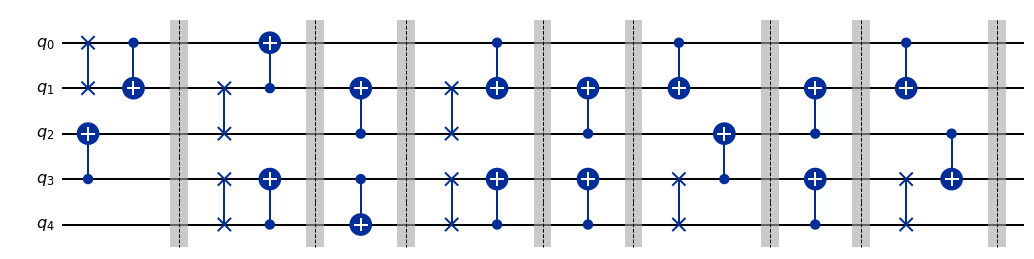

In [19]:
def draw_circuit(L, T, p, r):
    
    layers = create_circuit_layers(L, T, p, r)
    qc = QuantumCircuit(L)
    for layer in layers:
        qc = qc.compose(layer)
        qc.barrier()
        
    return qc
    
    
L = 5
T = 8  
p = 0.5
r = 0.5 

draw_circuit(L, T, p, r).draw('mpl')   

----
## Integrated OTOC (iOTOC)

The following function allows us to compute the integrated OTOC for the Pauli operators sigma $Z(t)$ fixed at the middle of the circuit and sigma $X$ executing all the qubits, the iOTOC is defined as: $f(t) = - \sum_j \langle [\sigma_i^z(t), \sigma_j ^x ]^2 \rangle$. In this code is computed through the exact conmutator of the Pauli operators $Z$ and $X$ on the qubits, so that it consumes a lot of calculation time.

In [3]:
def U_at_time(layers, time):
    if not (0 <= time < len(layers)):
        raise IndexError("time fuera de rango")
    U = Operator(layers[0])
    for idx in range(1, time+1):
        U = Operator(layers[idx]) @ U

    return U

def Clifford_at_time(layers, time, n_qubits):
    if not (0 <= time < len(layers)):
        raise IndexError("t fuera de rango")
    
    qc = QuantumCircuit(n_qubits)
    
    for layer in layers[:time+1]:
        qc.compose(layer, inplace=True)   

    return Clifford(qc)

def satate_at_time(layers, time, n_qubits):
    if not (0 <= time < len(layers)):
        raise IndexError("t fuera de rango")
    
    qc = QuantumCircuit(n_qubits)
    
    for layer in layers[:time+1]:
        qc.compose(layer, inplace=True)    
    
    psi = Statevector.from_instruction(qc)
    return psi

def heisenberg_evolve_pauli(n_qubits, layers, init_site, time):
    """
    Evolve the operator W_i(0) = Z_i / sqrt(2) in Heisenberg picture
    through each layer, returning a list of SparsePauliOp objects.
    """
    # initial Pauli string: Z on init_site, I elsewhere
    z_pauli = ['I'] * n_qubits
    z_pauli[init_site] = 'Z'
    W = SparsePauliOp(Pauli(''.join(reversed(z_pauli))), 1/np.sqrt(2))
    
    U = U_at_time(layers, time)
    
    W_mat = U.adjoint().data @ W.to_matrix() @ U.data
    W = SparsePauliOp.from_operator(Operator(W_mat))
    
    return W


def compute_Cij(W: SparsePauliOp, j: int, n_qubits: int, state):
    """
    Compute C_{i,j}(t) 
    """
    # Build V_j
    x_pauli = ['I'] * n_qubits
    x_pauli[j] = 'X'
    V = SparsePauliOp(Pauli(''.join(reversed(x_pauli))), 1/np.sqrt(2))

    # comm = Pauli.commutes(W, V)
    # Convert to matrices
    Wm = W.to_matrix()
    Vm = V.to_matrix()

    comm = Wm @ Vm - Vm @ Wm
    comm2 = comm @ comm
    
    return -state.expectation_value(comm2) 


def compute_iOTOC(n_qubits, time, layers, init_site):
    """
    Main function: builds layers, evolves W_i, and computes f(t) for all t.
    Returns:
        times: list of t=0..time
        f_vals: list of iOTOC values
    """
    
    f_vals = []
    for t in range(time):
        state = satate_at_time(layers, t, n_qubits)
        Wt = heisenberg_evolve_pauli(n_qubits, layers, init_site, t)
        C_vals = [compute_Cij(Wt, j, n_qubits, state) for j in range(n_qubits)]
        f_vals.append(sum(C_vals))
    return list(range(len(f_vals))), np.real(f_vals), layers


----
## iOTOC density

As is presented in the paper, the iOTOC in this case is just the number of sigma $Z$ operators in the string of sigma $Z(t)$ at time t (envolving under Heisenberg picture), in order to compute the iOTOC is defined the function `compute_iOTOC_counts`, which envolves the sigma $Z$ operators in the circuit, and then counts the number of sigma $Z$ operators in the string of sigma $Z(t)$, and extracting the positions where appear, in this way is much more efficient than the previous function.

In [4]:
def density_paulis(pauli_str):
    """
    Compute the density of Z Pauli operators in a given string.
    """
    pauli_str = pauli_str.to_label()   
    length = len(pauli_str)
    center = length // 2
    z_positions = [i - center for i, op in enumerate(pauli_str) if op == 'Z']
    
    return z_positions, len(z_positions)

def counts_paulis(pauli_str):
    """
    Compute the density of Z Pauli operators in a given string.
    """
    count = 0
    pauli_str = pauli_str.to_label()
    for op in pauli_str:
        if op == 'Z':
            count += 1
    return count

def compute_iOTOC_counts(n_qubits, time, layers, init_site):

    """
    Compute the iOTOC for a given time, p, and r, counting the number of Z paulis operators.
    """
    #layers = create_circuit_layers(n_qubits, time, p, r)
    # Build W_i(0)
    Z_pauli_initial = ['I'] * n_qubits
    Z_pauli_initial[init_site] = 'Z'
    W = Pauli("".join(Z_pauli_initial))
    
    counts = []
    positions = []
    
    for t in range(time):
        U = Clifford_at_time(layers, t, n_qubits)
        Wt = W.evolve(U)  # Evolve the Pauli operator with U
        pos, count = density_paulis(Wt)
        counts.append(count)
        positions.append(pos)
        
    return list(range(len(counts))), counts, positions

def compute_butterfly_velocity(positinos, n_qubits):
    left_values = []
    right_values = []

    for i in range(len(positinos)):
        left_values.append(positinos[i][0])
        right_values.append(positinos[i][-1])
            
        if positinos[i][0] == -n_qubits // 2 or positinos[i][-1] == n_qubits // 2:
            break

    left_fit = np.polyfit(range(len(left_values)), left_values, 1)
    right_fit = np.polyfit(range(len(right_values)), right_values, 1)
    left_slope = -left_fit[0]
    right_slope = right_fit[0]


    return (np.mean([left_slope, right_slope]))
    

----
## Samall test for running-time
Below is a small test in which both methods are compared, observing that both results agree, and as the second method is much more efficient than the first.

Execution time for compute_iOTOC: 0.9457 seconds


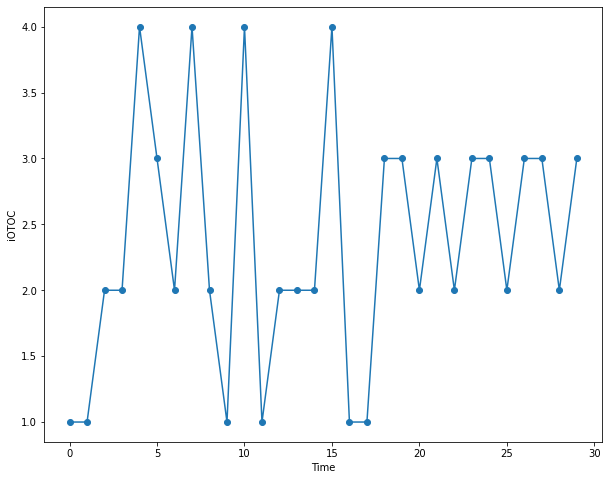

Execution time for compute_iOTOC_counts: 0.0761 seconds


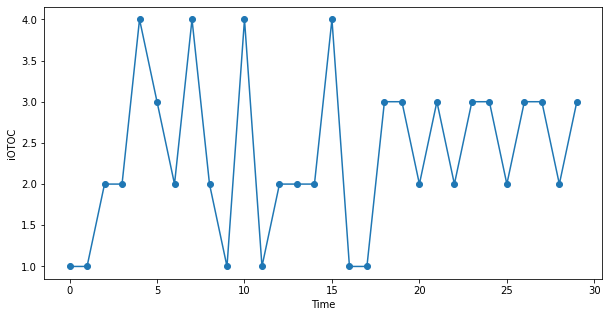

In [ ]:
L = 5
T = 30  
p = 0.9
r = 0.5

layers = create_circuit_layers(L, T, p, r)

start_time1 = time.time()
iOTOC_times1, iOTOC_vals1, layers = compute_iOTOC(L, T, layers, init_site=L//2)
end_time1 = time.time()
print(f"Execution time for compute_iOTOC: {end_time1 - start_time1:.4f} seconds")    
    
plt.figure(figsize=(10, 8))
plt.plot(iOTOC_times1, iOTOC_vals1, marker='o')
plt.xlabel('Time')
plt.ylabel('iOTOC')
plt.show()

start_time2 = time.time()
iOTOC_times2, iOTOC_vals2, density = compute_iOTOC_counts(L, T, layers, init_site=L//2)
end_time2 = time.time()
print(f"Execution time for compute_iOTOC_counts: {end_time2 - start_time2:.4f} seconds")

plt.figure(figsize=(10, 5))
plt.plot(iOTOC_times2, iOTOC_vals2, marker='o')
plt.xlabel('Time')
plt.ylabel('iOTOC')
plt.show()



---
## Example for usign functions 
An example of iotoc in a large circuit in a single iteration, which shows noise in the iotoc, can also see the exponential growth of the iotoc and the linear regime. The spatial density of Iotoc is also presented as a cone of light as expected.

Execution time for compute_iOTOC_counts: 96.8991 seconds
Butterfly velocity:  0.4347326830472896


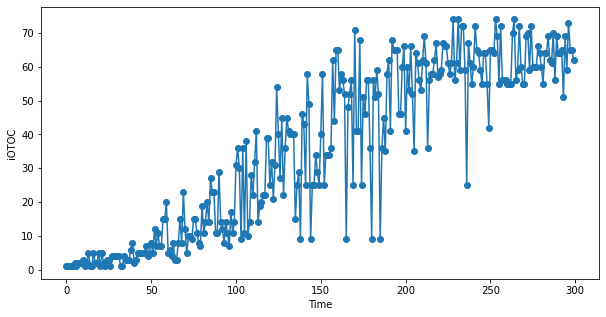

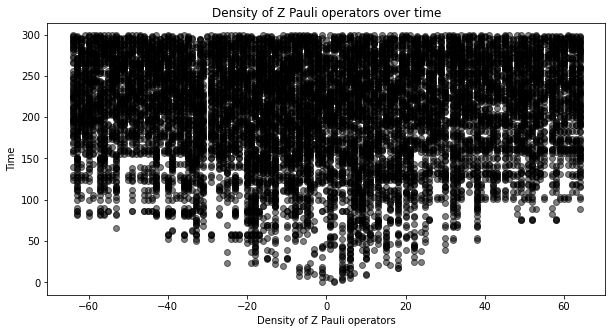

In [24]:
L = 129
T = 300
p = 0.9
r = 0.05

layers = create_circuit_layers(L,T, p, r)

start_time = time.time()
iOTOC_times, iOTOC_vals, density = compute_iOTOC_counts(L, T, layers, init_site=L//2)
end_time = time.time()
print(f"Execution time for compute_iOTOC_counts: {end_time - start_time:.4f} seconds")

Butterfly_velocity = compute_butterfly_velocity(density, L)
print("Butterfly velocity: ", Butterfly_velocity)

plt.figure(figsize=(10, 5))
plt.plot(iOTOC_times, iOTOC_vals, marker='o')
plt.xlabel('Time')
plt.ylabel('iOTOC')
plt.show()

plt.figure(figsize=(10, 5))
for i in range(len(density)):
    plt.scatter(density[i], [i]*len(density[i]), marker='o', color='black', alpha=0.5)
 
plt.xlabel('Density of Z Pauli operators')
plt.ylabel('Time')
plt.title('Density of Z Pauli operators over time')
plt.show()


---
## Averaging the iOTOC over ensembles
In order to improve the resolution of the iOTOC (decrease the noise), is neccesary perform a large number of iterations, and then average the results. 

In [ ]:
def single_OTOC(n_qubits, t, layers, W):
    U = Clifford_at_time(layers, t, n_qubits)
    Wt = W.evolve(U)
    z_positions, count = density_paulis(Wt)
    return z_positions, count

def run_OTOC_instance(n_qubits, time, layers, W):
    return [single_OTOC(n_qubits, t, layers, W) for t in range(time)]

def test(n_qubits, time, p, r, W):
    layers = create_circuit_layers(n_qubits, time, p, r)
    return run_OTOC_instance(n_qubits, time, layers, W)

def compute_iOTOC_counts_savedata(iteration, n_qubits, time, p, r, init_site):
    filename = f"iOTOC_n{n_qubits}_t{time}_p{p}_r{r}.dat"
    filepath = os.path.join("numerical_data", filename)

    Z_pauli_initial = ['I'] * n_qubits
    Z_pauli_initial[init_site] = 'Z'
    W = Pauli("".join(Z_pauli_initial))
    
    all_results = Parallel(n_jobs=-1)(
        delayed(test)(n_qubits, time, p, r, W) for i in range(iteration)
    )

    results_by_time = list(zip(*all_results))

    with open(filepath, "w") as f:
        f.write("t\tiOTOC\tDensities\n")
        for t, results_at_t in enumerate(results_by_time):
            counts = [count for _, count in results_at_t]
            iOTOC = np.mean(counts)

            all_positions = [pos for pos_list, _ in results_at_t for pos in pos_list]
            position_counts = Counter(all_positions)
            densities = {pos: position_counts[pos] / iteration for pos in sorted(position_counts)}
            densities_str = " ".join(f"{pos}:{densities[pos]:.4f}" for pos in densities)

            f.write(f"{t}\t{iOTOC:.6f}\t{densities_str}\n")
     
     

---
## Extracting the Lyapunov exponent and butterfly velocity

To extract the lyapunov exponent and butterfly velocity, it is necessary to adjust the iOTOC with the function $ f(t) = a e^{\lambda_l t} + b $, for short times, where $ a $ and $ B $ are constant, and $\lambda_l $ is the lyapunov exponent. The butterfly velocity ($v_B$) is defined and computed as the slope in the spatial density of the iotoc, and it is the growth rate of the velocity in the linear regime, before the saturated regime.


In [20]:
def compute_butterfly_velocity_from_file(filepath, n_qubits, epsilon=1e-3):
    left_values = []
    right_values = []

    with open(filepath, "r") as f:
        lines = f.readlines()[1:]  # saltar encabezado

    for t, line in enumerate(lines):
        parts = line.strip().split("\t")
        if len(parts) < 3:
            continue  # si no hay densidades, salta

        density_str = parts[2]
        densities = {}
        for item in density_str.split():
            pos, val = item.split(":")
            densities[int(pos)] = float(val)

        # Filtrar por epsilon
        active_positions = [pos for pos, dens in densities.items() if dens >= epsilon]
        if not active_positions:
            continue

        left = min(active_positions)
        right = max(active_positions)

        left_values.append(left)
        right_values.append(right)

        # Condición de paro opcional si llega a los bordes del sistema
        if left <= -n_qubits // 2 or right >= n_qubits // 2:
            break

    # Ajuste lineal
    t_values = range(len(left_values))
    left_fit = np.polyfit(t_values, left_values, 1)
    right_fit = np.polyfit(t_values, right_values, 1)

    left_slope = -left_fit[0]
    right_slope = right_fit[0]

    return np.mean([left_slope, right_slope])

def plot(filepath, L, t_exp_max, t_lin_min, t_lin_max=None):

    # --- Data reading ---
    times, iOTOC_vals = [], []
    density_data = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.startswith("t"):
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            t = float(parts[0])
            y = float(parts[1])
            times.append(t)
            iOTOC_vals.append(y)
            dens = {}
            for pair in parts[2:]:
                if ':' in pair:
                    pos, d = pair.split(':')
                    dens[int(pos)] = float(d)
            density_data.append(dens)

    t = np.array(times)
    y = np.array(iOTOC_vals)

    # --- Region masks ---
    mask_exp = t <= t_exp_max
    t_exp = t[mask_exp]
    y_exp = y[mask_exp]
    if np.any(y_exp <= 0):
        raise ValueError("iOTOC ≤ 0 in exponential region; You can't take logarithm.")
    # Exponential adjustment: ln y = ln A + λ t
    coeffs = np.polyfit(t_exp, np.log(y_exp), 1)
    λ, lnA = coeffs[0], coeffs[1]
    A = np.exp(lnA)

    mask_lin = t >= t_lin_min
    if t_lin_max is not None:
        mask_lin &= (t <= t_lin_max)
    t_lin = t[mask_lin]
    y_lin = y[mask_lin]
    # Linear fit
    v, b, r_val, p_val, stderr = linregress(t_lin, y_lin)

    # --- Print parameters ---
    print(f"Lyapunov exponent λ   = {λ:.5f}")
    print(f"Slope C_sat*v         = {v:.5f}")
    Butterfly_velocity = compute_butterfly_velocity_from_file(filepath, L)
    print("Butterfly Velocity:    = ", Butterfly_velocity)
    # --- Plot iOTOC vs Time---
    plt.figure(figsize=(10, 6))
    plt.plot(t, y, 'o', ms=4, label='iOTOC simulation')

    # Exponential adjustment
    t_fit_exp = np.linspace(t_exp.min(), t_exp.max(), 200)
    y_fit_exp = A * np.exp(λ * t_fit_exp)
    plt.plot(t_fit_exp, y_fit_exp, '-',
             label=f'Exp fit: $A e^{{λt}}$, λ={λ:.3f}', linewidth=3)

    # Linear adjustment
    t_fit_lin = np.linspace(t_lin.min(), t_lin.max(), 200)
    y_fit_lin = v * t_fit_lin + b
    plt.plot(t_fit_lin, y_fit_lin, '-', 
             label=f'Linear fit: $C_s v t + b$, C_sat *v ={v:.3f}', linewidth=3)

    plt.xlabel('Time')
    plt.ylabel('iOTOC')
    plt.title('iOTOC vs Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Heat map density position ---
    positions = sorted({p for dens in density_data for p in dens})
    idx_map = {p:i for i,p in enumerate(positions)}
    heat = np.zeros((len(density_data), len(positions)))
    for ti, dens in enumerate(density_data):
        for p,d in dens.items():
            heat[ti, idx_map[p]] = d

    plt.figure(figsize=(12, 6))
    plt.imshow(heat, origin='lower', aspect='auto',
               extent=[min(positions), max(positions), t.min(), t.max()])
    plt.colorbar(label='Density')
    plt.xlabel('Position')
    plt.ylabel('Time')
    plt.title('Heat map density vs Time')
    plt.ylim(0, 200)
    plt.tight_layout()
    plt.show()

    return λ, v

---
## Results  
This section includes plots of the integrated OTOC with the respective fits used to extract $\lambda_L$ and $v_B$. The number of qubits is fixed at $N=129$, and the parameters $p$ and $r$ are varied.


In [ ]:
L = 129
T = 500
p = 0.9
r = 0.05

iteration = 1000

start_time = time.time()     
compute_iOTOC_counts_savedata(iteration, L, T, p, r, init_site=L//2)
end_time = time.time()
print(f"Execution time for compute all iOTOC_counts: {end_time - start_time:.4f} seconds")

---
## $p=0.9$, $r=0.05$

Lyapunov exponent λ   = 0.03689
Slope C_sat*v         = 0.38932
Butterfly Velocity:    =  0.9717719780219779


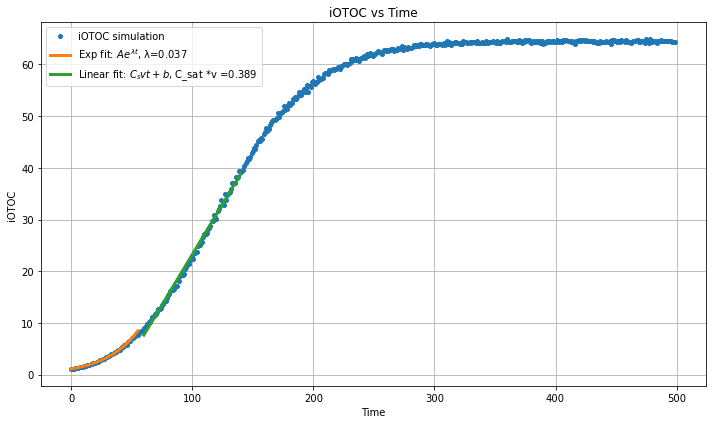

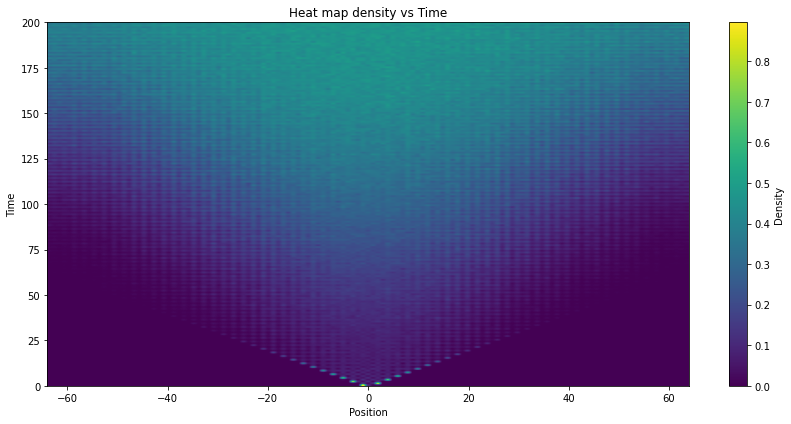

In [30]:
L = 129
T = 500
p = 0.9
r = 0.05
t_scrambling = 55

filepath = f"numerical_data/iOTOC_n{L}_t{T}_p{p}_r{r}.dat"  # Ajusta según corresponda
res1 = plot(filepath, L,
                   t_exp_max=t_scrambling,
                   t_lin_min=t_scrambling + 5,
                   t_lin_max=140,
                   )

---
## $p=0.9$, $r=0.02$

In [15]:
L = 129
T = 500
p = 0.9
r = 0.02

iteration = 1000

start_time = time.time()     
compute_iOTOC_counts_savedata(iteration, L, T, p, r, init_site=L//2)
end_time = time.time()
print(f"Execution time for compute all iOTOC_counts: {end_time - start_time:.4f} seconds")

Execution time for compute all iOTOC_counts: 23734.9428 seconds


Lyapunov exponent λ   = 0.01445
Slope C_sat*v         = 0.05446
Butterfly Velocity:    =  0.9537202380952381


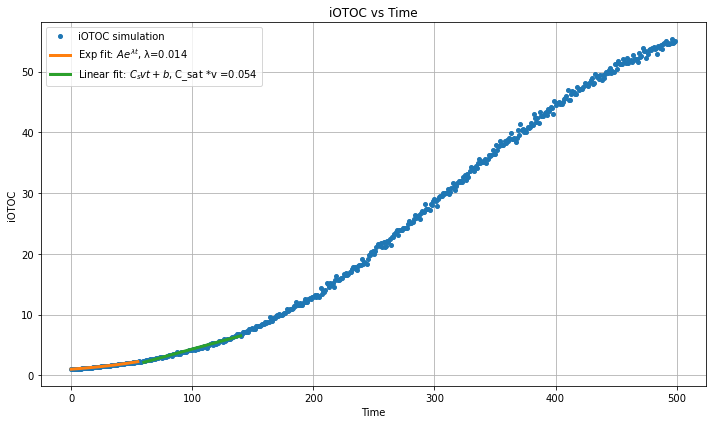

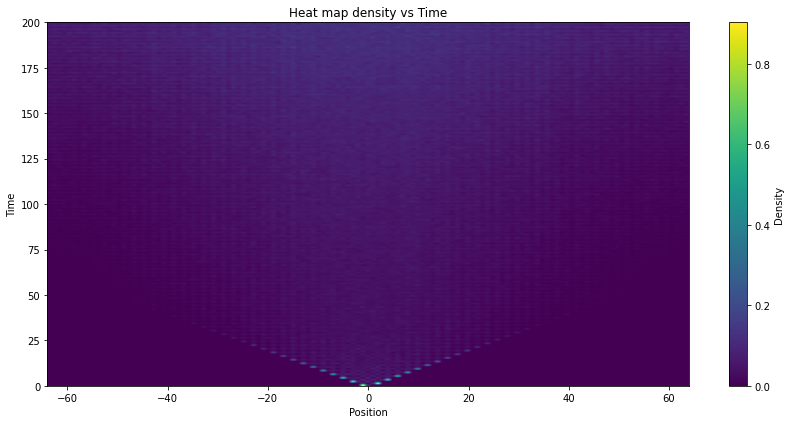

In [7]:
L = 129
T = 500
p = 0.9
r = 0.02
t_scrambling = 55

filepath = f"numerical_data/iOTOC_n{L}_t{T}_p{p}_r{r}.dat"  # Ajusta según corresponda
res1 = plot(filepath, L,
                   t_exp_max=t_scrambling,
                   t_lin_min=t_scrambling + 5,
                   t_lin_max=140,
                   )

---
## $p=1$, $r=0.05$

In [ ]:
L = 129
T = 500
p = 1
r = 0.05

iteration = 1000

start_time = time.time()     
compute_iOTOC_counts_savedata(iteration, L, T, p, r, init_site=L//2)
end_time = time.time()
print(f"Execution time for compute all iOTOC_counts: {end_time - start_time:.4f} seconds")

Lyapunov exponent λ   = 0.04080
Slope C_sat*v         = 0.50844
Butterfly Velocity:    =  1.0


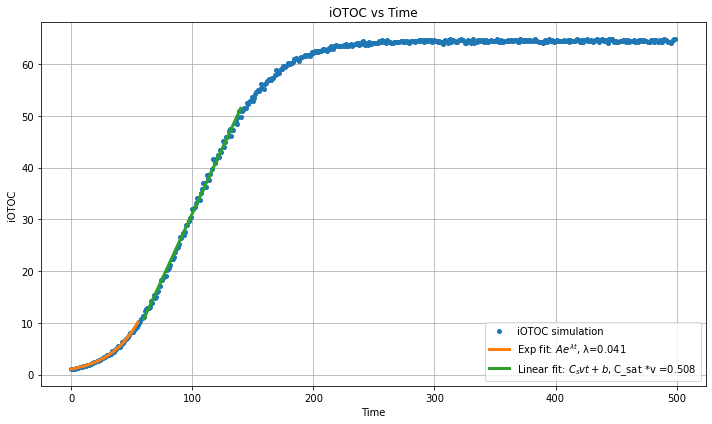

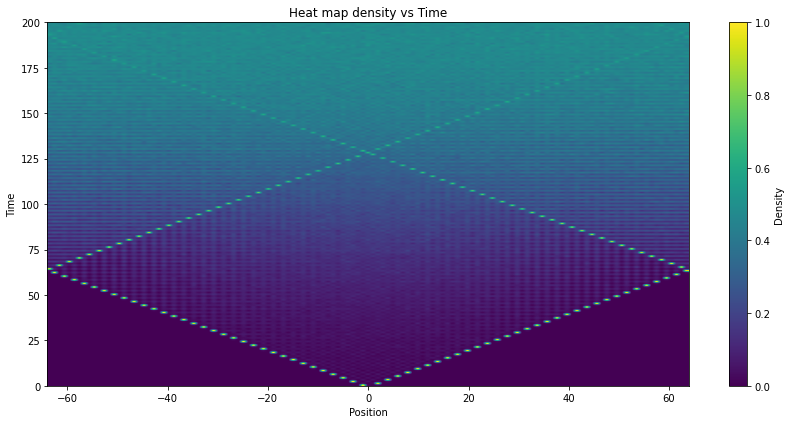

In [31]:
L = 129
T = 500
p = 1
r = 0.05
t_scrambling = 55

filepath = f"numerical_data/iOTOC_n{L}_t{T}_p{p}_r{r}.dat"  # Ajusta según corresponda
res2 = plot(filepath, L,
                   t_exp_max=t_scrambling,
                   t_lin_min=t_scrambling + 5,
                   t_lin_max=140,
                   )

---
## $p=1$, $r=0.02$

In [16]:
L = 129
T = 500
p = 1
r = 0.02

iteration = 1000

start_time = time.time()     
compute_iOTOC_counts_savedata(iteration, L, T, p, r, init_site=L//2)
end_time = time.time()
print(f"Execution time for compute all iOTOC_counts: {end_time - start_time:.4f} seconds")

Execution time for compute all iOTOC_counts: 25336.1766 seconds


Lyapunov exponent λ   = 0.01516
Slope C_sat*v         = 0.06356
Butterfly Velocity:    =  1.0


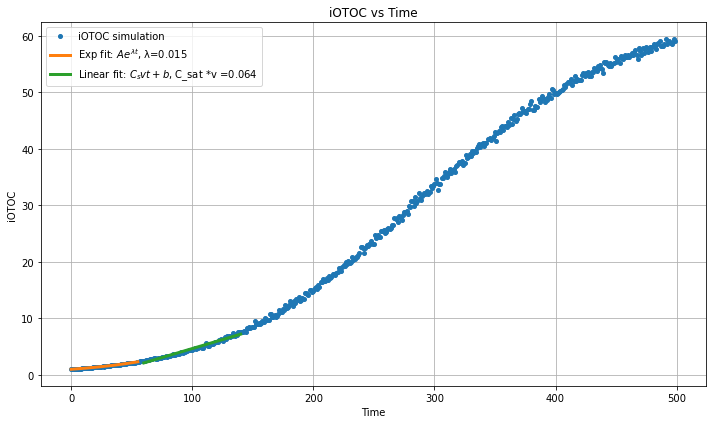

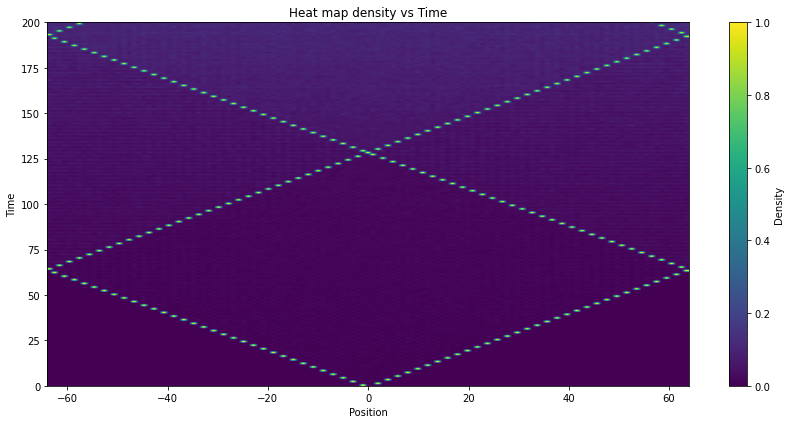

In [8]:
L = 129
T = 500
p = 1
r = 0.02
t_scrambling = 55

filepath = f"numerical_data/iOTOC_n{L}_t{T}_p{p}_r{r}.dat"  # Ajusta según corresponda
res2 = plot(filepath, L,
                   t_exp_max=t_scrambling,
                   t_lin_min=t_scrambling + 5,
                   t_lin_max=140,
                   )

---
## $p=0.9$, $r=0.5$

In [10]:
L = 129
T = 200
p = 0.9
r = 0.5

iteration = 1000

start_time = time.time()     
compute_iOTOC_counts_savedata(iteration, L, T, p, r, init_site=L//2)
end_time = time.time()
print(f"Execution time for compute all iOTOC_counts: {end_time - start_time:.4f} seconds")

Execution time for compute all iOTOC_counts: 6816.7442 seconds


Lyapunov exponent λ   = 0.10453
Slope C_sat*v         = 0.65640
Butterfly Velocity:    =  0.976304945054945


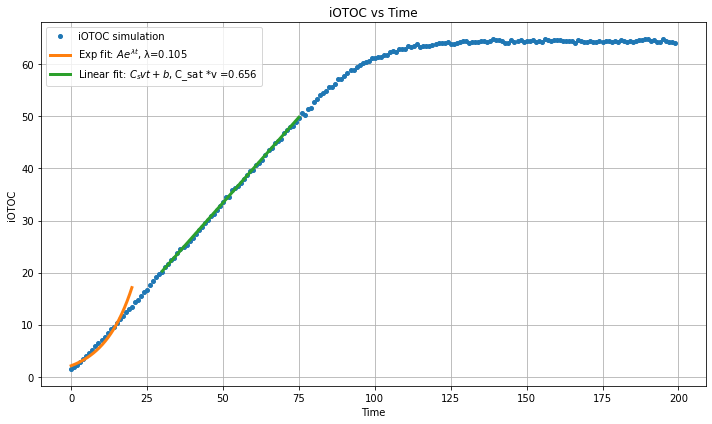

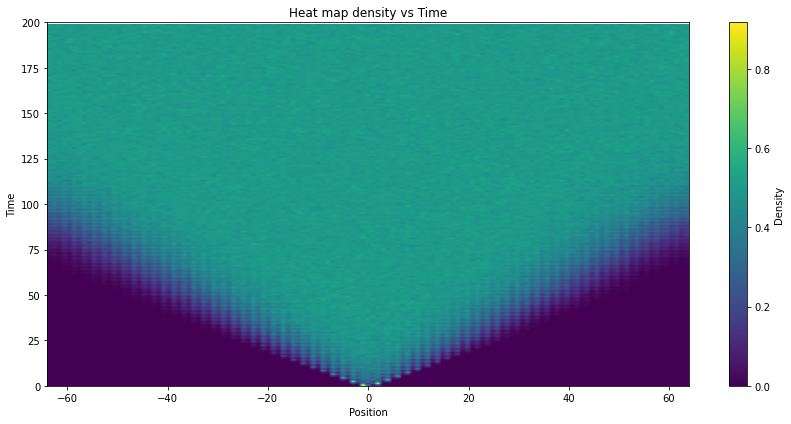

In [13]:
L = 129
T = 200
p = 0.9
r = 0.5
t_scrambling = 20

filepath = f"numerical_data/iOTOC_n{L}_t{T}_p{p}_r{r}.dat"  # Ajusta según corresponda
res = plot(filepath, L,
                   t_exp_max=t_scrambling,
                   t_lin_min=t_scrambling+10,
                   t_lin_max=75,
                   )

---
## $p=0.5$, $r=0.05$

In [ ]:
L = 129
T = 700
p = 0.5
r = 0.05

iteration = 1000

start_time = time.time()     
compute_iOTOC_counts_savedata(iteration, L, T, p, r, init_site=L//2)
end_time = time.time()
print(f"Execution time for compute all iOTOC_counts: {end_time - start_time:.4f} seconds")

Execution time for compute all iOTOC_counts: 30664.6249 seconds


Lyapunov exponent λ   = 0.02484
Slope C_sat*v         = 0.15014
Butterfly Velocity:    =  0.2773966367880062


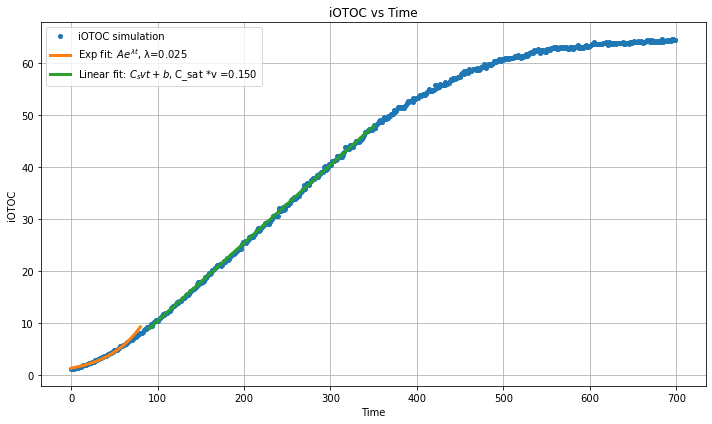

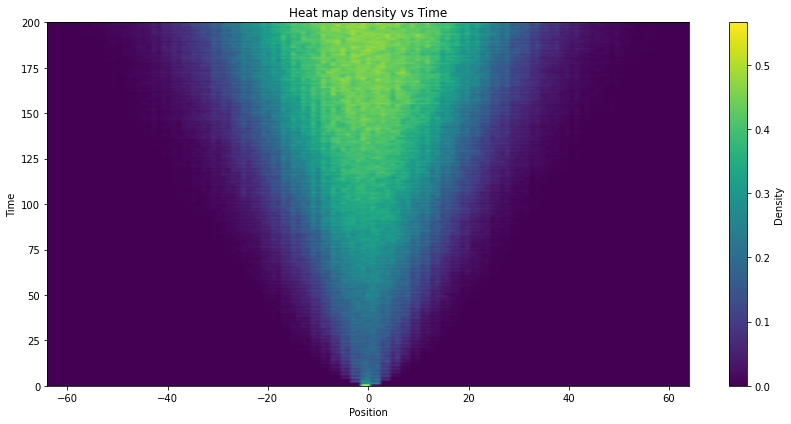

In [12]:
L = 129
T = 700
p = 0.5
r = 0.05
t_scrambling = 80

filepath = f"numerical_data/iOTOC_n{L}_t{T}_p{p}_r{r}.dat"  # Ajusta según corresponda
res = plot(filepath, L,
                   t_exp_max=t_scrambling,
                   t_lin_min=t_scrambling+10,
                   t_lin_max=350,
                   )

---
# Conclusions

In the ballistic case ($p=1$), the butterfly velocity is $v_B = 1$, basically because the propagation of sigma $Z$ operator doesn't have obstacles, while in the diffusive case ($p<1$), the butterfly velocity is $v_B < 1$, that is, the scrambling take more time for occupy the entire chain of qubits. The $r$ parameter allow us to set the interactions between qubits, and therefore density of iOTOC depends on this parameter, for small values ​​of $r$ the intensity in the heat map is low, and it increases with $r$.